<a href="https://colab.research.google.com/github/seetarajpara/Module5_Capstone_ProteinClassificationProject/blob/main/SRajpara_Module5_Capstone_ProteinClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Protein Classification Problem

### Background Research
- Proteins are macromolecules responsible for all biological processes in living cells
- They are made up of amino acid chains, making up a larger sequence of these molecules
    - Further, each amino acid type is determined by the underlying DNA sequence in a gene
- The sequence of amino acids influence how the proteins fold, which dictates the function of the protein
- Protein function is a vast area of research in biotechnology, and understanding this further is critical for developing therapeutics and precision diagnostics 

<img src= "https://www.ebi.ac.uk/training/online/courses/protein-classification-intro-ebi-resources/wp-content/uploads/sites/96/2020/07/figure1.png" width=400>

<a href="https://www.ebi.ac.uk/training/online/courses/protein-classification-intro-ebi-resources/protein-classification/" target="_blank">image source</a>

### Purpose
- Proteins can be classified by their physical properties; but these classifications tend to be very general
- Amino acids each have unique physical and chemical properties, so when we have this kind of data, we can make broad generalizations of the protein function overall
- More specific classifications can be made, however, by analyzing the amino acid sequence itself
- The order of each amino acid within the longer chain is crucial for protein function, and other arrangements of these building blocks results in a totally different protein with different function

*** 
- Some examples of how these amino acid building blocks influence protein function:
    - Active sites on proteins contain amino acids involved in catalytic activity
        - Example: Lipase catalyses the formation and hydrolysis of fats --> has two amino acid residues (a histidine followed by a glycine) that are essential for its catalytic activity
    - Binding sites contain amino acids that are directly involved in binding molecules or ions
        - Example: Iron-binding site of haemoglobin
    - Post-translational modification (PTM) sites contain residues known to be chemically modified (phosphorylated, palmitoylated, acetylated, etc) after the process of protein translation
    - Repeats are typically short amino acid sequences that are repeated within a protein
***

### Dataset
- We have 2 .csv files of data: 
    - `pdb_data_no_dups.csv` provides physical properties of the protein
        - properties (numeric): residue count, pH, crystallization temperature, resolution, molecular weight, and density
            - residue count: number of amino acids in the sequence
            - pH: scale determining acidity or basicity of a solution (e.g. acidic solutions have a pH < 7.0 and basic solutions have pH > 7.0)
            - crystallization temperature: temperature at which the protein crystallizes (precipitates out of solution during crystallization process)
            - resolution: measure of the quality of the data that has been collected on the crystal containing the protein
            - molecular weight: molecular mass of a given molecule (expressed in kilo Daltons, kDa)
            - density: 
        - target label is provided here, as "classification" of the protein type (e.g. ligase, transferase, oxidoreductase, etc.)
    - `pdb_data_seq.csv` provides the amino acid sequence for each protein
    #### target label:
    - `classification`

    #### categorical vars: 
    - `experimentalTechnique`
    - `crystallizationMethod`
    - `pdbxDetails`
    - `publicationYear`
    - `sequence`

    #### numerical vars:
    - `residueCount`
    - `resolution`
    - `structureMolecularWeight`
    - `crystallizationTempK`
    - `densityMatthews`
    - `densityPercentSol`
    - `phValue`


### Problem Statement
- Classify the protein type/function using information provided in the dataset
- Evaluate performance of models

### Sources
1. https://www.ebi.ac.uk/training/online/courses/protein-classification-intro-ebi-resources/protein-classification/
2. https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/introduction

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
pwd

'/content/drive/My Drive/Module 5 Capstone'

In [78]:
cd /content/drive/My Drive/Module 5 Capstone/

/content/drive/My Drive/Module 5 Capstone


In [79]:
ls

draft_Copy1.ipynb  pdb_data_no_dups.csv  pdb_data_seq.csv


In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import itertools
import tensorflow as tf
import tensorflow_hub as hub

In [81]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.constraints import max_norm
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from tensorflow.keras import datasets, layers, models, Sequential
from keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Flatten, 
                                     Conv1D, MaxPooling1D, Dropout, 
                                     GlobalMaxPooling1D, Activation, 
                                     Embedding, Bidirectional, LSTM, 
                                     BatchNormalization)

In [82]:
from collections import Counter
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (classification_report,accuracy_score,
                             precision_score,recall_score,f1_score, 
                             confusion_matrix, precision_recall_curve)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   LabelBinarizer)

In [83]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Exploratory Data Analysis 

In [84]:
data = pd.read_csv('pdb_data_no_dups.csv')
seq = pd.read_csv('pdb_data_seq.csv')

In [85]:
data.head(1)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.9,6360.3,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0


In [86]:
seq.head(1)

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid


In [87]:
# select only protein for macromolecule type
data = data[data.macromoleculeType == 'Protein']

In [88]:
# delete columns macromoleculeType, residueCount, structureId
data = data.drop(['macromoleculeType',
                  'pdbxDetails',
                  'structureId'], axis=1)

In [89]:
#data['experimentalTechnique'].value_counts()

In [90]:
counts = data.experimentalTechnique.value_counts()
hello = np.asarray(counts[(counts > 96)].index)

In [91]:
data = data[data.experimentalTechnique.isin(hello)]
#data.head()

In [92]:
#data['crystallizationMethod'].value_counts()[:20]

In [93]:
counts = data.crystallizationMethod.value_counts()
hello = np.asarray(counts[(counts > 100)].index)

In [94]:
data = data[data.crystallizationMethod.isin(hello)]
#data.head()

In [95]:
data["crystallizationMethod"].replace({"VAPOR DIFFUSION, HANGING DROP" : "VAPOR DIFFUSION", 
                                       "VAPOR DIFFUSION, SITTING DROP" : "VAPOR DIFFUSION", 
                                       "VAPOR DIFFUSION" : "VAPOR DIFFUSION", 
                                       "EVAPORATION" : "EVAPORATION", 
                                       "MICROBATCH" : "MICROBATCH", 
                                       "hanging drop" : "VAPOR DIFFUSION", 
                                       "LIPIDIC CUBIC PHASE" : "LIPIDIC CUBIC PHASE", 
                                       "SMALL TUBES" : "Miscellaneous", 
                                       "MICRODIALYSIS" : "MICRODIALYSIS", 
                                       "BATCH MODE" : "MICROBATCH", 
                                       "LIQUID DIFFUSION" : "Miscellaneous", 
                                       "VAPOR DIFFUSION,SITTING DROP,NANODROP" : "VAPOR DIFFUSION", 
                                       "batch" : "MICROBATCH", 
                                       "microbatch under oil" : "MICROBATCH", 
                                       "VAPOR DIFFUSION, SITTING DROP, NANODROP" : "VAPOR DIFFUSION"}, 
                                      inplace=True)

In [96]:
data['crystallizationMethod'].value_counts()

VAPOR DIFFUSION        82455
MICROBATCH              1353
EVAPORATION              888
Miscellaneous            507
LIPIDIC CUBIC PHASE      336
MICRODIALYSIS            256
Name: crystallizationMethod, dtype: int64

In [97]:
#data['classification'].value_counts()[:20]

In [98]:
#data['classification'].value_counts()[:20]
counts = data.classification.value_counts()
hello = np.asarray(counts[(counts > 829)].index)

In [99]:
data = data[data.classification.isin(hello)]

In [100]:
missing_data = []

for col in data.columns:
    if data[col].isnull().sum() > 0:
        missing_data.append(col)
    
missing_data

['resolution',
 'crystallizationTempK',
 'densityMatthews',
 'densityPercentSol',
 'phValue',
 'publicationYear']

In [101]:
# replace null values in numeric vars with mean: 
# resolution, crystallizationMethod, crystallizationTempK,
# densityMatthews, densityPercentSol, phValue, publicationYear

def impute_mean(df, col):
    mean_val=df[col].mean()
    df[col].fillna(mean_val,inplace=True)

In [102]:
impute_mean(data, 'resolution')
impute_mean(data, 'crystallizationTempK')
impute_mean(data, 'densityMatthews')
impute_mean(data, 'densityPercentSol')
impute_mean(data, 'phValue')
impute_mean(data, 'publicationYear')

In [103]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
residueCount,63222.0,750.535636,939.836898,7.00,296.00,485.000000,868.00,57792.00
resolution,63222.0,2.100655,0.539171,0.48,1.75,2.000000,2.40,10.00
structureMolecularWeight,63222.0,84765.852948,103938.621116,836.81,33813.86,55024.795000,97835.54,4918807.00
crystallizationTempK,63222.0,290.981367,8.534965,4.00,290.00,293.000000,295.00,398.00
densityMatthews,63222.0,2.641340,0.657995,0.00,2.22,2.470000,2.86,13.89
densityPercentSol,63222.0,51.146664,9.559680,0.00,44.47,50.200000,57.00,92.00
phValue,63222.0,6.788657,1.255814,0.00,6.00,6.788657,7.50,100.00
publicationYear,63222.0,2010.667512,4.520523,1988.00,2008.00,2010.667512,2014.00,2018.00


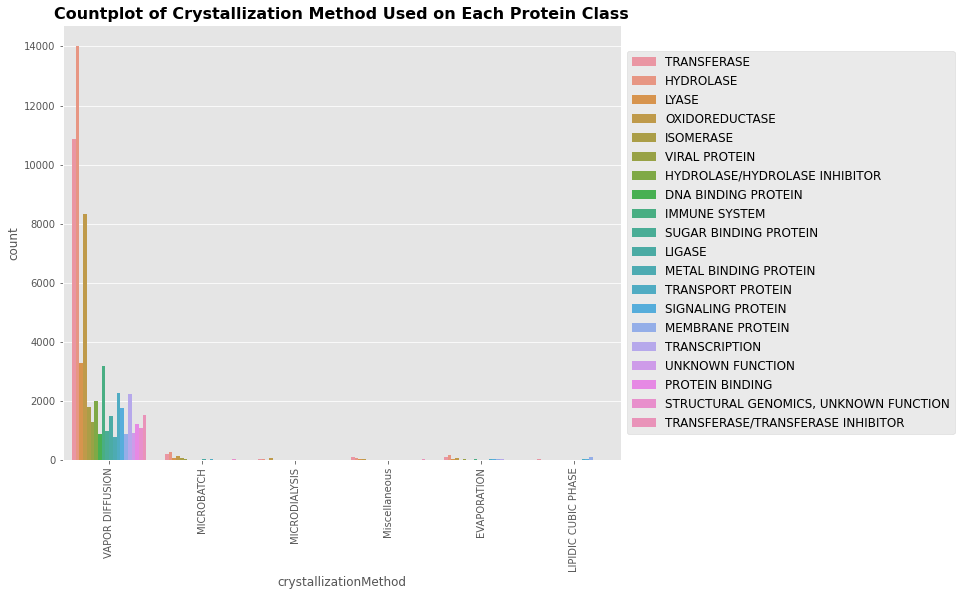

In [104]:
# count plots of crystallizationMethod vs. classification
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.xlabel('crystallization method', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title("Countplot of Crystallization Method Used on Each Protein Class",fontsize=16, fontweight='bold')
plt.xticks(rotation=90)
g = sns.countplot(x=data['crystallizationMethod'], data=data, hue='classification')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

In [105]:
# crystallization method and experimental technique do not matter
# only feed numerical values to model
data = data.drop(['crystallizationMethod',
                  'experimentalTechnique'], 
                  axis=1)

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63222 entries, 224 to 141319
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   classification            63222 non-null  object 
 1   residueCount              63222 non-null  int64  
 2   resolution                63222 non-null  float64
 3   structureMolecularWeight  63222 non-null  float64
 4   crystallizationTempK      63222 non-null  float64
 5   densityMatthews           63222 non-null  float64
 6   densityPercentSol         63222 non-null  float64
 7   phValue                   63222 non-null  float64
 8   publicationYear           63222 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 7.3+ MB


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

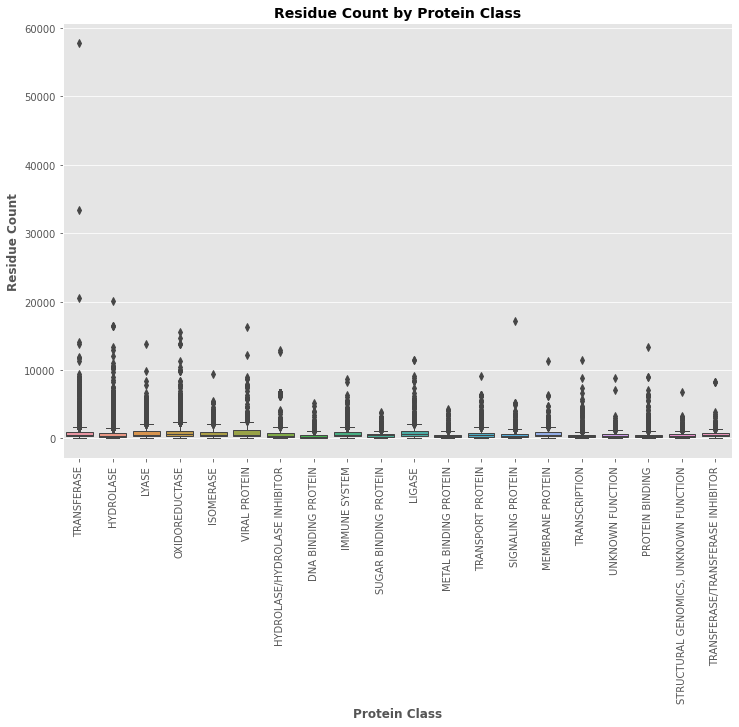

In [107]:
# boxplots
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['residueCount'], x=data['classification'], linewidth=1)
plt.title('Residue Count by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('Residue Count', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

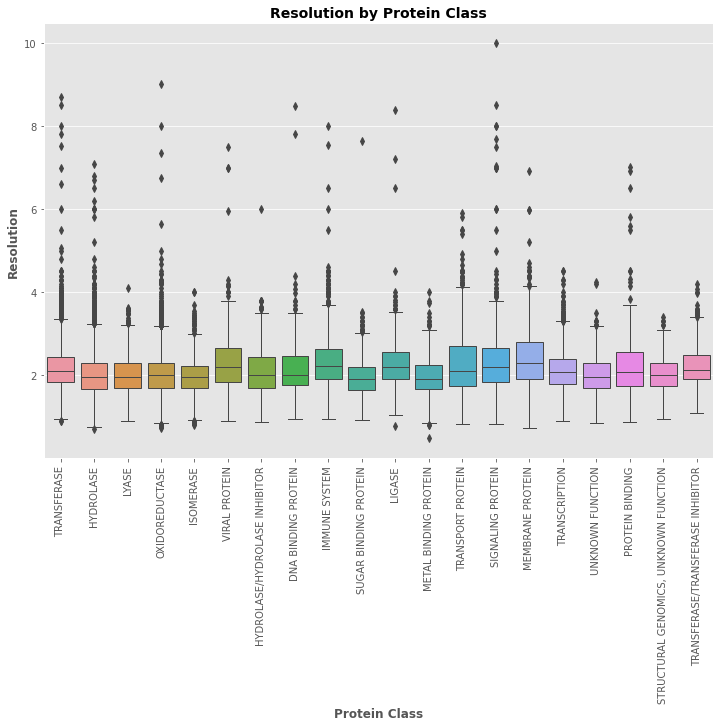

In [108]:
# boxplots
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['resolution'], x=data['classification'], linewidth=1)
#plt.ylim(0.5,4)
plt.title('Resolution by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('Resolution', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

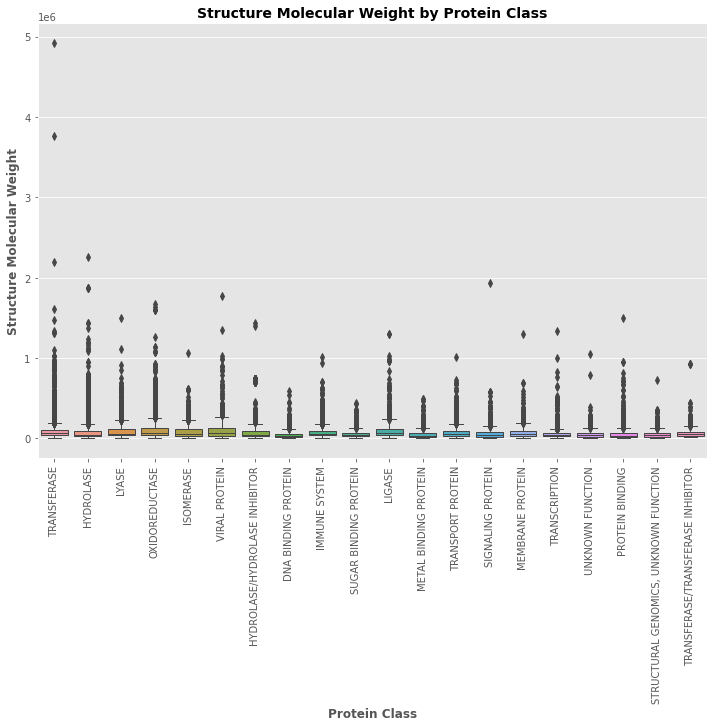

In [109]:
# structureMolecularWeight
# boxplots
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['structureMolecularWeight'], x=data['classification'], linewidth=1)
#plt.ylim(0,300000)
plt.title('Structure Molecular Weight by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('Structure Molecular Weight', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

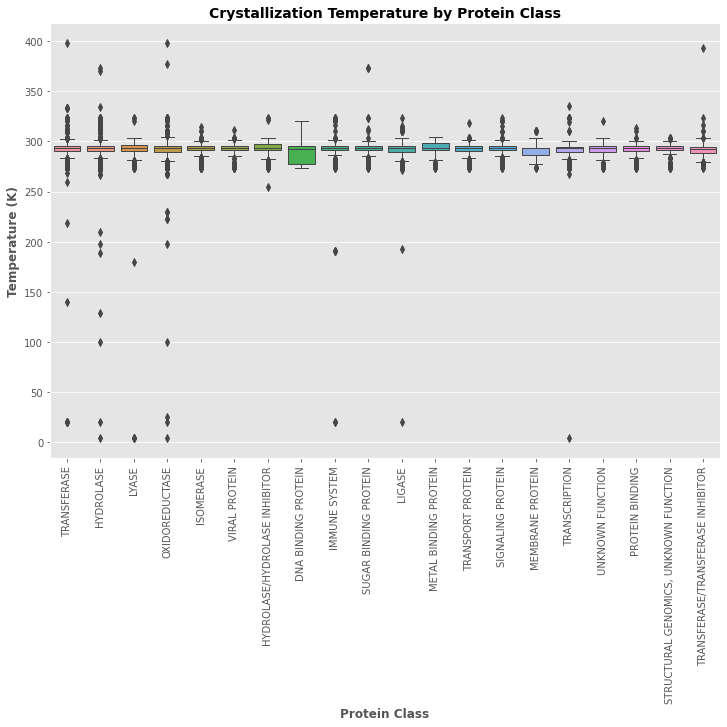

In [110]:
#crystallizationTempK
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['crystallizationTempK'], x=data['classification'], linewidth=1)
#plt.ylim(280,300)
plt.title('Crystallization Temperature by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('Temperature (K)', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

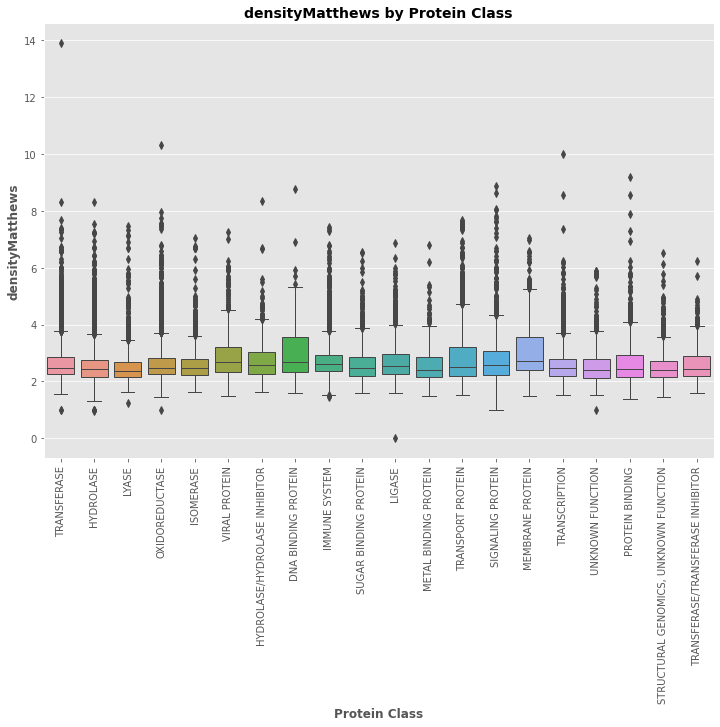

In [111]:
#densityMatthews
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['densityMatthews'], x=data['classification'], linewidth=1)
#plt.ylim(1.5,4)
plt.title('densityMatthews by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('densityMatthews', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

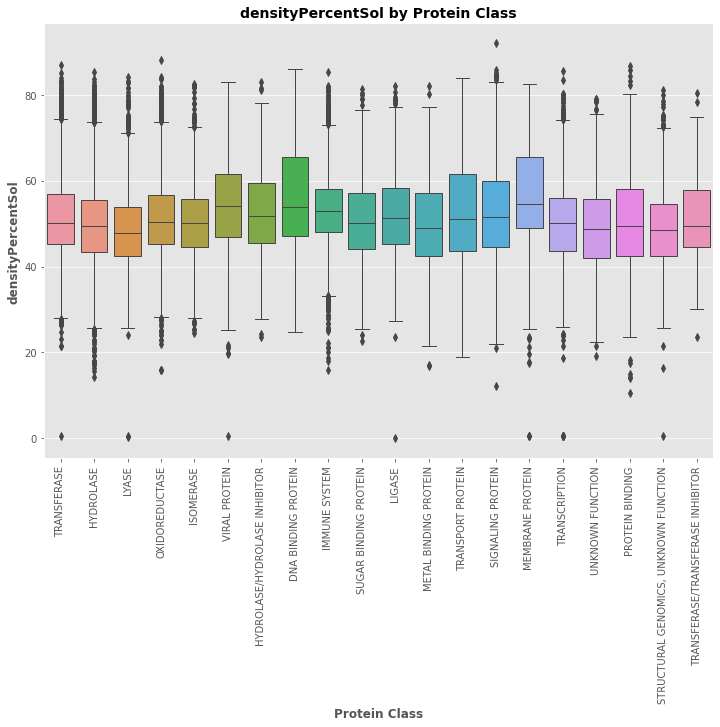

In [112]:
#densityPercentSol
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['densityPercentSol'], x=data['classification'], linewidth=1)
#plt.ylim(23, 70)
plt.title('densityPercentSol by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('densityPercentSol', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

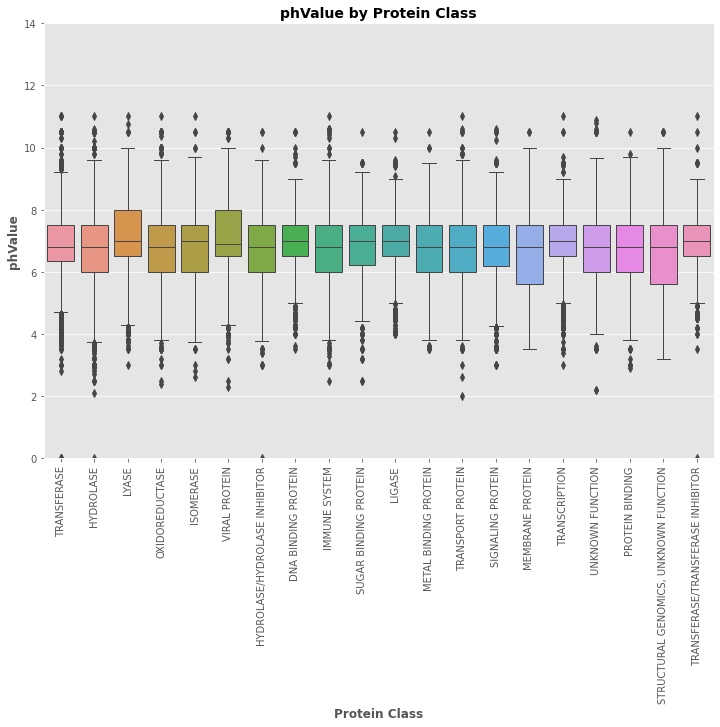

In [113]:
#phValue
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['phValue'], x=data['classification'], linewidth=1)
plt.ylim(0,14)
plt.title('phValue by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('phValue', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

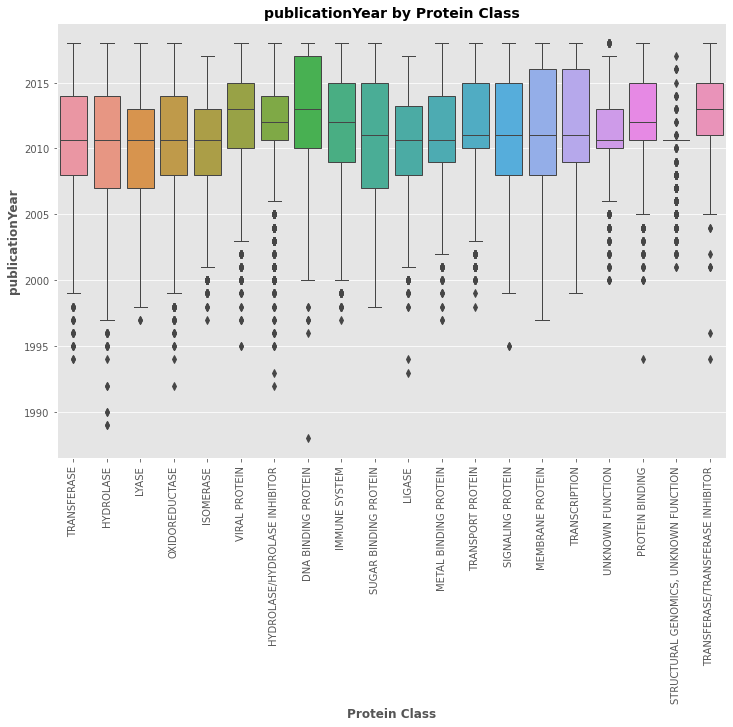

In [114]:
#publicationYear
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['publicationYear'], x=data['classification'], linewidth=1)
#plt.ylim(1990, 2020)
plt.title('publicationYear by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('publicationYear', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

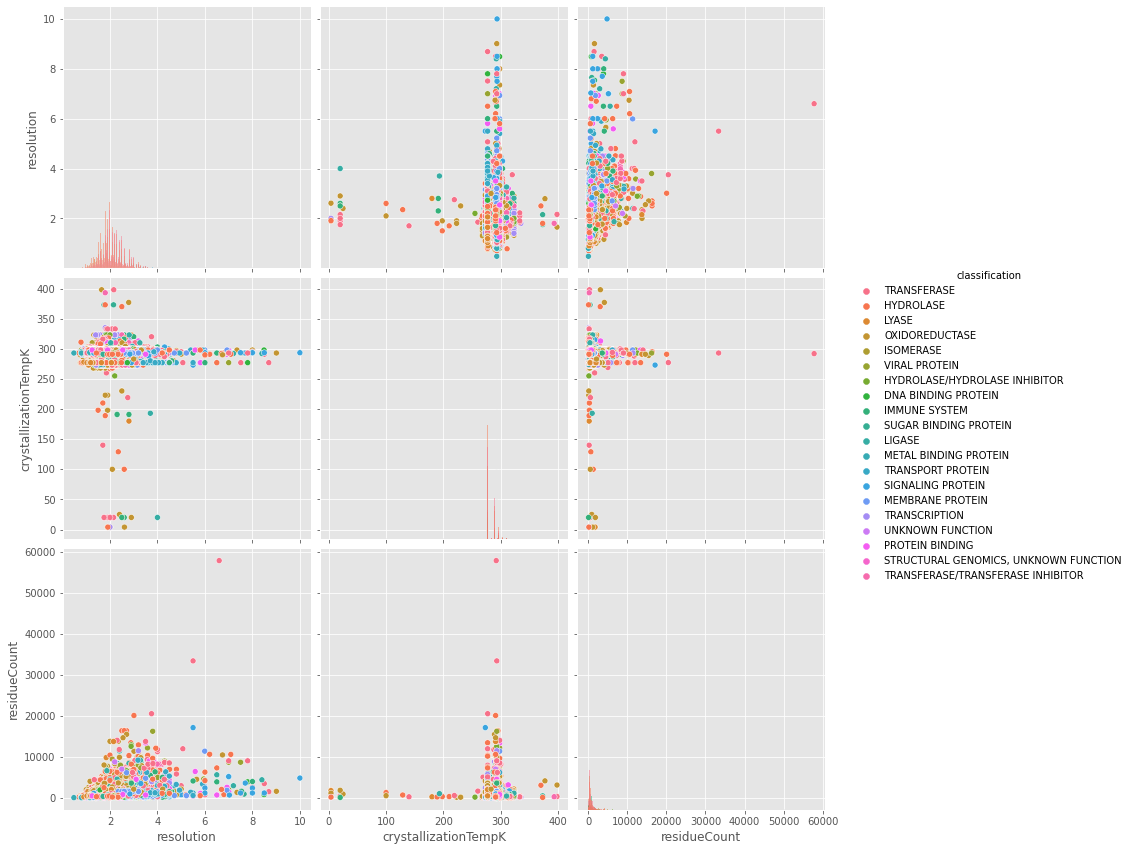

In [115]:
sns.pairplot(data[['resolution', 
                   'crystallizationTempK', 
                   'residueCount', 
                   'classification']],
             hue='classification', 
             height=4, 
             diag_kind='hist')

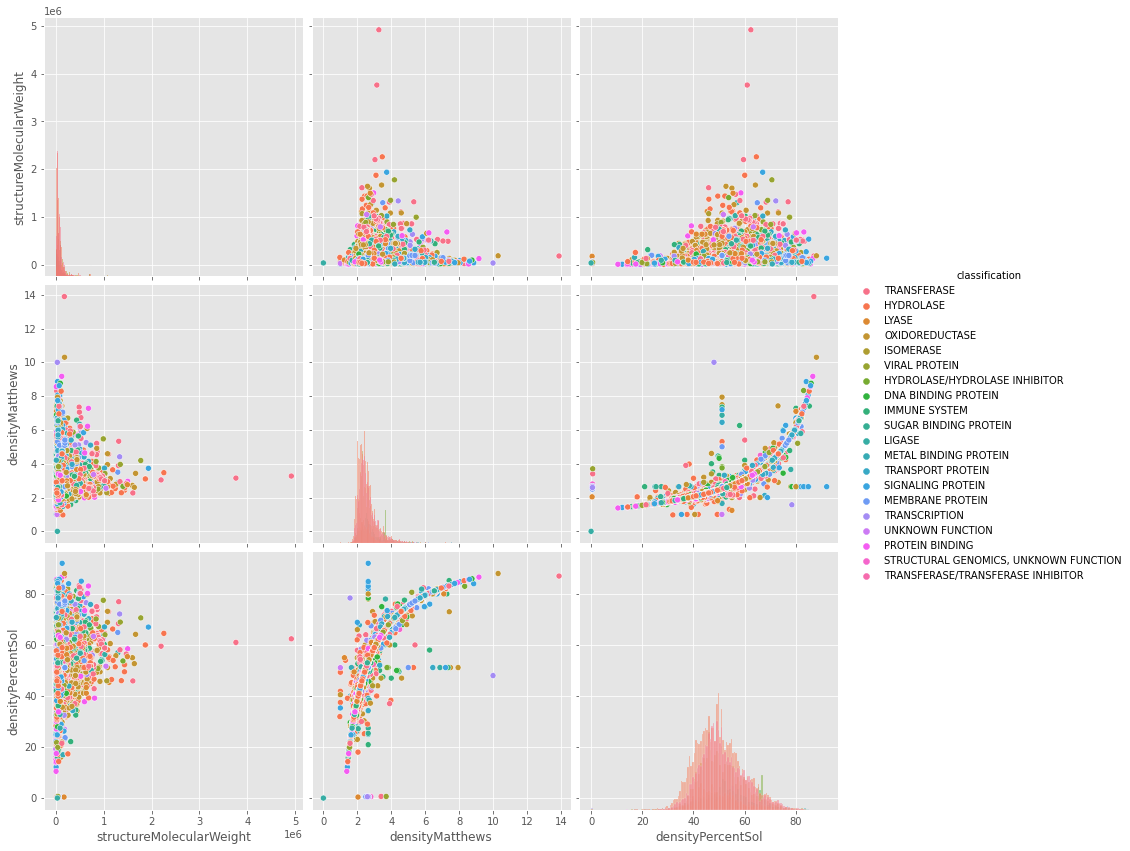

In [116]:
sns.pairplot(data[['structureMolecularWeight', 
                   'densityMatthews', 
                   'densityPercentSol', 
                   'classification']],
             hue='classification', 
             height=4, 
             diag_kind='hist')

### EDA Interpretations

- Plots show that these variables likely do not influence protein classification
- The variables analyzed here specify mostly physical and chemical properties of the proteins
- We could do some regression analyses on the numerical variables but considering how these initial plots look, I'd hypothesize these parameters would not deliver a strong classification model
- We know that AA sequences influence protein function and all machine learning models in this notebook will focus on this

### Sequence Analysis

In [117]:
data = pd.read_csv('pdb_data_no_dups.csv')
seq = pd.read_csv('pdb_data_seq.csv')

In [118]:
df_intermediate = seq.merge(data, on='structureId', how='left')
df_intermediate.head()

,structureId,chainId,sequence,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
2,101D,A,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
3,101D,B,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [119]:
df_intermediate.drop_duplicates(subset=['structureId'], keep='first', inplace=True)
df_intermediate.head()

,structureId,chainId,sequence,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
2,101D,A,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
5,102D,A,CGCAAATTTGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
7,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [120]:
# select only protein for macromolecule type
df_intermediate = df_intermediate[df_intermediate.macromoleculeType_x == 'Protein']

In [121]:
df_intermediate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127387 entries, 4 to 471145
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               127387 non-null  object 
 1   chainId                   127387 non-null  object 
 2   sequence                  127384 non-null  object 
 3   residueCount_x            127387 non-null  int64  
 4   macromoleculeType_x       127387 non-null  object 
 5   classification            127386 non-null  object 
 6   experimentalTechnique     127387 non-null  object 
 7   macromoleculeType_y       127387 non-null  object 
 8   residueCount_y            127387 non-null  int64  
 9   resolution                116602 non-null  float64
 10  structureMolecularWeight  127387 non-null  float64
 11  crystallizationMethod     87325 non-null   object 
 12  crystallizationTempK      88287 non-null   float64
 13  densityMatthews           114122 non-null  f

In [122]:
# delete columns macromoleculeType, residueCount, structureId
df_intermediate = df_intermediate.drop(['macromoleculeType_x',
                                        'macromoleculeType_y',
                                        'chainId',
                                        'residueCount_x',
                                        'residueCount_y',
                                        'resolution',
                                        'structureMolecularWeight',
                                        'crystallizationMethod',
                                        'crystallizationTempK',
                                        'densityMatthews',
                                        'densityPercentSol',
                                        'phValue',
                                        'publicationYear',
                                        'pdbxDetails',
                                        'structureId',
                                        'experimentalTechnique'], axis=1)

In [123]:
df_intermediate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127387 entries, 4 to 471145
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   sequence        127384 non-null  object
 1   classification  127386 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


In [124]:
def impute_mode(df, col):
    mode_category=df[col].mode()[0]
    df[col].fillna(mode_category,inplace=True)

In [125]:
impute_mode(df_intermediate, 'sequence')

In [126]:
impute_mode(df_intermediate, 'classification')

In [127]:
data = df_intermediate

In [128]:
data.head()

,sequence,classification
4,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
7,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,HYDROLASE(O-GLYCOSYL)
8,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
11,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,HYDROLASE(O-GLYCOSYL)
12,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT


In [129]:
data['seq_char_count']= data['sequence'].apply(lambda x: len(x))

In [130]:
def plot_seq_count(df):
    sns.distplot(df['seq_char_count'].values, color='b')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Sequence Character Count')
    plt.grid(True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


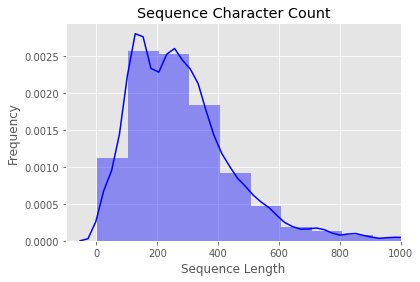

In [131]:
plt.style.use('ggplot')
plot_seq_count(data)
plt.xlim(-100,1000)
plt.show()

In [132]:
def get_code_freq(df):
    
    df = df.apply(lambda x: " ".join(x))
    
    codes = []
    
    for i in df: # concatination of all codes
        codes.extend(i)

    codes_dict= Counter(codes)
    codes_dict.pop(' ') # removing white space
    
    df = pd.DataFrame({'Amino Acid': list(codes_dict.keys()), 'Frequency': list(codes_dict.values())})
    return df.sort_values('Frequency', ascending=False).reset_index()[['Amino Acid', 'Frequency']]

In [133]:
code_freq = get_code_freq(data['sequence'])
code_freq

,Amino Acid,Frequency
0,L,3299786
1,A,2858951
2,G,2712474
3,V,2499381
4,E,2364910
5,S,2310140
6,K,2097751
7,D,2095220
8,T,2029384
9,I,2008386


In [134]:
def plot_code_freq(df):
    plt.title('Amino Acid Frequency')
    sns.barplot(x='Amino Acid', y='Frequency', data=df)

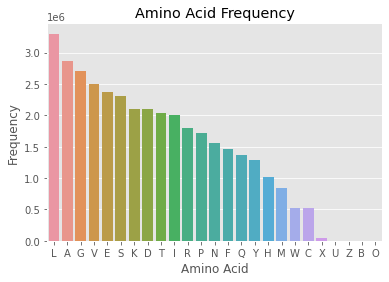

In [135]:
plot_code_freq(code_freq)
plt.show()

In [136]:
sequences = data.sequence.values
lengths = [len(s) for s in sequences]

In [137]:
# mean length of a sequence - will use this as a max input length for models
np.mean(lengths)

285.9119062384702

In [138]:
data['classification'].value_counts()[:20]

HYDROLASE                                20383
TRANSFERASE                              15340
OXIDOREDUCTASE                           12173
LYASE                                     4239
IMMUNE SYSTEM                             3989
TRANSCRIPTION                             3479
TRANSPORT PROTEIN                         3174
SIGNALING PROTEIN                         2845
HYDROLASE/HYDROLASE INHIBITOR             2650
ISOMERASE                                 2531
VIRAL PROTEIN                             2257
LIGASE                                    2076
PROTEIN BINDING                           1867
MEMBRANE PROTEIN                          1708
TRANSFERASE/TRANSFERASE INHIBITOR         1682
STRUCTURAL GENOMICS, UNKNOWN FUNCTION     1647
DNA BINDING PROTEIN                       1413
METAL BINDING PROTEIN                     1342
SUGAR BINDING PROTEIN                     1318
CELL ADHESION                             1274
Name: classification, dtype: int64

In [139]:
# only keep top 20 classifications
counts = data.classification.value_counts()
hello = np.asarray(counts[(counts > 1273)].index)

In [140]:
data = data[data.classification.isin(hello)]

In [ ]:
# count plot of classification
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.xlabel('classification', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title("Countplot of Each Protein Class (Top 20)",fontsize=16, fontweight='bold')
plt.xticks(rotation=90)
g = sns.countplot(x=data['classification'], data=data, hue='classification')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

### Machine Learning Models
#### *Using sequence analysis to predict protein classification*
<img src= "https://openclipart.org/image/800px/95191" width=400>

- The image above shows the codon sequences that make up each amino acid
- Ordered sequences of these AAs define a specific function of the resulting encoded protein
- Use tokenizer to encode sequence characters

#### Convolutional Neural Networks (CNN)
- `model_0`
  - Sequential base, building 1-dimensional convolutional and pooling layers
  - Semi-qualitative model, treating the sequence input as some sort of image or pattern
    - One caveat is that these sequences don't all start with the same starting codon, therefore they have similar segments but are not necessarily aligned neatly
    - If they were aligned and we had all equal fragments of sequences, this approach might be successful
  - This baseline is just being used to see what our results look like with a CNN model although this is not the model I hypothesize will be iterated on for fine tuning

#### Recurring Neural Networks (RNN)
- RNN is a type of artificial neural network which uses sequential data or time series data
- Commonly used for ordinal or temporal problems, such as language translation, natural language processing (NLP), speech recognition, and image captioning
- RNN take information from prior inputs to influence the current input and output
- Output of RNNs depend on the prior elements within the sequence
- Future events would also be helpful in determining the output of a given sequence, use **bidirectional RNNs** to account for these events in their predictions

In [141]:
X = data['sequence']
y = data['classification']

In [142]:
# encode classification labels
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

In [143]:
# encode sequences using tokenizer
# create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)
# represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=285)

In [144]:
# number of distinct characters stored in variable max_id
# this will be part of the input shape (reps each AA)
max_id = len(tokenizer.word_index)
max_id

25

In [145]:
# total number of characters 
dataset_size = tokenizer.document_count
dataset_size

87387

In [146]:
# split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

In [147]:
# confirm shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69909, 285), (17478, 285), (69909, 20), (17478, 20))

In [148]:
def plot_model_results(model):
    
    accuracy = model.history.history['accuracy']
    loss = model.history.history['loss']
    
    val_accuracy = model.history.history['val_accuracy']
    val_loss = model.history.history['val_loss']
    
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    
    plt.ylabel('% accuracy')
    plt.xlabel('Epoch')
    #plt.ylim(0.1, 1.0)
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Model Loss')
    
    plt.ylabel('% loss')
    plt.xlabel('Epoch')
    #plt.ylim(0.1, 1.0)
    plt.legend()
    plt.show()

In [149]:
# create the model
model_0 = Sequential()

# The model will take as input an integer matrix of size (25,20,285)
# and the largest integer (i.e. word index) in the input 
# Now model.output_shape is (None, 10, 64), where `None` is the batch
# dimension.
model_0.add(Embedding(25, 20, input_length=285))

model_0.add(Conv1D(filters=128, kernel_size=12, padding='same', activation='relu'))
model_0.add(MaxPooling1D(pool_size=2))

model_0.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model_0.add(MaxPooling1D(pool_size=2))

model_0.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_0.add(MaxPooling1D(pool_size=2))

model_0.add(Flatten())
model_0.add(Dense(285, activation='relu'))
model_0.add(Dense(20, activation='softmax'))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode= 'max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_0.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 285, 20)           500       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 285, 128)          30848     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 142, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 142, 64)           49216     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 71, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 71, 32)            6176      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 35, 32)           

In [150]:
model_0.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=early_stopping)

Epoch 1/50
2185/2185 [==============================] - 11s 5ms/step - loss: 1.8685 - accuracy: 0.4271 - val_loss: 1.4739 - val_accuracy: 0.5570
Epoch 2/50
2185/2185 [==============================] - 10s 5ms/step - loss: 1.2535 - accuracy: 0.6258 - val_loss: 1.1999 - val_accuracy: 0.6532
Epoch 3/50
2185/2185 [==============================] - 10s 5ms/step - loss: 0.9479 - accuracy: 0.7154 - val_loss: 1.1268 - val_accuracy: 0.6867
Epoch 4/50
2185/2185 [==============================] - 10s 5ms/step - loss: 0.7501 - accuracy: 0.7700 - val_loss: 1.1074 - val_accuracy: 0.7012
Epoch 5/50
2185/2185 [==============================] - 10s 5ms/step - loss: 0.6164 - accuracy: 0.8068 - val_loss: 1.1201 - val_accuracy: 0.7195
Epoch 6/50
2185/2185 [==============================] - 10s 5ms/step - loss: 0.5153 - accuracy: 0.8370 - val_loss: 1.2269 - val_accuracy: 0.7192
Epoch 7/50
2185/2185 [==============================] - 10s 5ms/step - loss: 0.4525 - accuracy: 0.8542 - val_loss: 1.2902 - val_ac

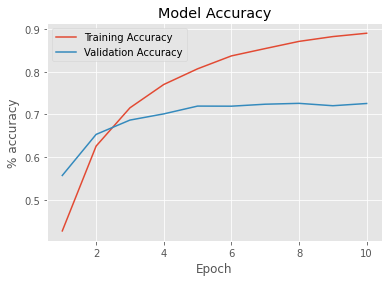

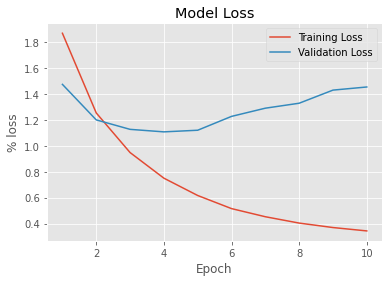

In [151]:
plot_model_results(model_0)

In [152]:
train_pred = model_0.predict(X_train)
test_pred = model_0.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.9013431746985366
test accuracy = 0.7258839684174391


`model_0` as a CNN model, I predicted this would not work well but I wanted to see if there was any patterns this model could recognize semi-qualitatively

In [153]:
# Compute confusion matrix
#cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#np.set_printoptions(precision=2)
#plt.figure(figsize=(7,7))
#plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title('Confusion matrix')
#plt.colorbar()
#tick_marks = np.arange(len(lb.classes_))
#plt.xticks(tick_marks, lb.classes_, rotation=90)
#plt.yticks(tick_marks, lb.classes_)
#plt.ylabel('True label')
#plt.xlabel('Predicted label')
#plt.show()

In [154]:
#print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

`model_1` 
- Add LSTM layer after setting input
- Proceed to adding hidden layers and use same optimization parameters as baseline model
- I predict this model will significantly outperform the CNN model from the baseline
- This is because the sequences of AA characters matter in a particular order; each cluster of specific AAs will encode a particular function for a protein

In [155]:
model_1 = Sequential()
model_1.add(Embedding(25, 20, input_length=285))

model_1.add(LSTM(25, return_sequences=True))

model_1.add(Flatten())
model_1.add(Dense(285, activation='sigmoid'))
model_1.add(Dense(20, activation='softmax'))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 285, 20)           500       
_________________________________________________________________
lstm (LSTM)                  (None, 285, 25)           4600      
_________________________________________________________________
flatten_2 (Flatten)          (None, 7125)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 285)               2030910   
_________________________________________________________________
dense_5 (Dense)              (None, 20)                5720      
Total params: 2,041,730
Trainable params: 2,041,730
Non-trainable params: 0
_________________________________________________________________


In [156]:
model_1.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=15, callbacks=early_stopping)

Epoch 1/15
2185/2185 [==============================] - 37s 16ms/step - loss: 1.8318 - accuracy: 0.4448 - val_loss: 1.3918 - val_accuracy: 0.5821
Epoch 2/15
2185/2185 [==============================] - 37s 17ms/step - loss: 1.2208 - accuracy: 0.6384 - val_loss: 0.8545 - val_accuracy: 0.7573
Epoch 3/15
2185/2185 [==============================] - 38s 17ms/step - loss: 0.8071 - accuracy: 0.7601 - val_loss: 0.5399 - val_accuracy: 0.8462
Epoch 4/15
2185/2185 [==============================] - 38s 17ms/step - loss: 0.5394 - accuracy: 0.8364 - val_loss: 0.3543 - val_accuracy: 0.8986
Epoch 5/15
2185/2185 [==============================] - 38s 17ms/step - loss: 0.3696 - accuracy: 0.8879 - val_loss: 0.2517 - val_accuracy: 0.9246
Epoch 6/15
2185/2185 [==============================] - 38s 17ms/step - loss: 0.2711 - accuracy: 0.9139 - val_loss: 0.2018 - val_accuracy: 0.9342
Epoch 7/15
2185/2185 [==============================] - 38s 17ms/step - loss: 0.2179 - accuracy: 0.9266 - val_loss: 0.1669 -

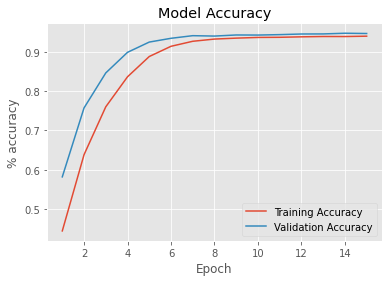

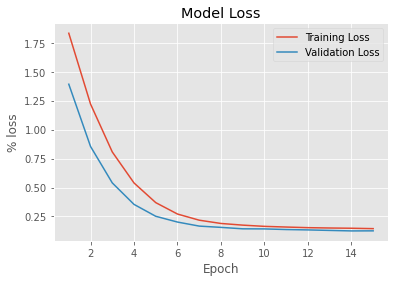

In [157]:
plot_model_results(model_1)

In [158]:
train_pred = model_1.predict(X_train)
test_pred = model_1.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.9463731422277533
test accuracy = 0.743677766334821


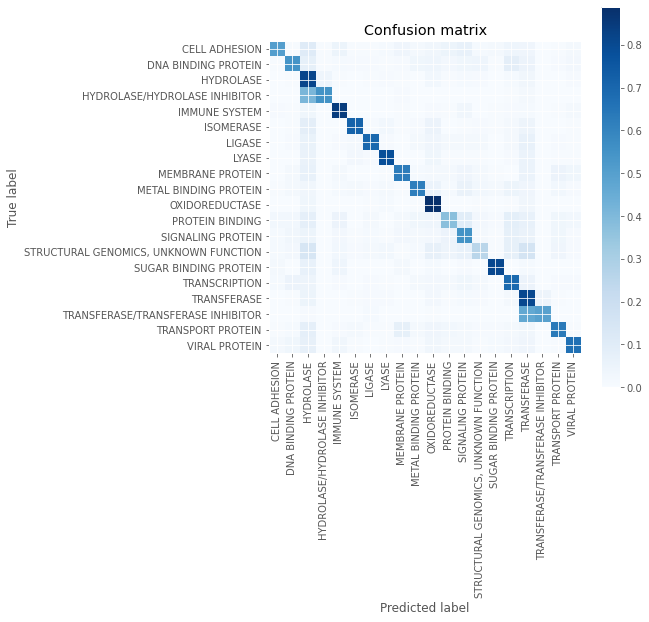

In [159]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [160]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                       precision    recall  f1-score   support

                        CELL ADHESION       0.63      0.51      0.56       259
                  DNA BINDING PROTEIN       0.49      0.55      0.52       278
                            HYDROLASE       0.79      0.81      0.80      4025
        HYDROLASE/HYDROLASE INHIBITOR       0.61      0.55      0.58       497
                        IMMUNE SYSTEM       0.83      0.84      0.84       786
                            ISOMERASE       0.80      0.71      0.75       519
                               LIGASE       0.71      0.70      0.70       401
                                LYASE       0.83      0.78      0.81       852
                     MEMBRANE PROTEIN       0.59      0.63      0.61       324
                METAL BINDING PROTEIN       0.58      0.62      0.60       274
                       OXIDOREDUCTASE       0.85      0.89      0.87      2477
                      PROTEIN BINDING       0.48   

`model_1` 
- Performed very well considering we're trying to classify into 20 labels
- The following protein types/classes were predicted with high precision:
                                        precision    recall  f1-score   support
                        IMMUNE SYSTEM       0.83      0.84      0.84       786
                            ISOMERASE       0.80      0.71      0.75       519
                                LYASE       0.83      0.78      0.81       852
                       OXIDOREDUCTASE       0.85      0.89      0.87      2477
                SUGAR BINDING PROTEIN       0.83      0.80      0.82       296

- 
`model_2`
- Adding bidirectional LSTM layer; however, since order of the sequence matters this might be a problem if the fragments are not all equal length (`max_length` = 285 AA's long)
- Source: https://keras.io/api/layers/recurrent_layers/bidirectional/

In [161]:
model_2 = Sequential()
model_2.add(Embedding(25, 20, input_length=285))

model_2.add(Bidirectional(LSTM(10, return_sequences=True)))

model_2.add(Flatten())
model_2.add(Dense(285, activation='sigmoid'))
model_2.add(Dense(20, activation='softmax'))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 285, 20)           500       
_________________________________________________________________
bidirectional (Bidirectional (None, 285, 20)           2480      
_________________________________________________________________
flatten_3 (Flatten)          (None, 5700)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 285)               1624785   
_________________________________________________________________
dense_7 (Dense)              (None, 20)                5720      
Total params: 1,633,485
Trainable params: 1,633,485
Non-trainable params: 0
_________________________________________________________________


In [162]:
model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=early_stopping)

Epoch 1/50
2185/2185 [==============================] - 53s 23ms/step - loss: 1.8281 - accuracy: 0.4483 - val_loss: 1.5210 - val_accuracy: 0.5434
Epoch 2/50
2185/2185 [==============================] - 53s 24ms/step - loss: 1.2475 - accuracy: 0.6297 - val_loss: 1.1719 - val_accuracy: 0.6679
Epoch 3/50
2185/2185 [==============================] - 55s 25ms/step - loss: 0.8443 - accuracy: 0.7502 - val_loss: 1.0367 - val_accuracy: 0.7150
Epoch 4/50
2185/2185 [==============================] - 55s 25ms/step - loss: 0.5673 - accuracy: 0.8297 - val_loss: 1.0134 - val_accuracy: 0.7338
Epoch 5/50
2185/2185 [==============================] - 55s 25ms/step - loss: 0.3910 - accuracy: 0.8799 - val_loss: 1.0515 - val_accuracy: 0.7341
Epoch 6/50
2185/2185 [==============================] - 55s 25ms/step - loss: 0.2863 - accuracy: 0.9096 - val_loss: 1.0796 - val_accuracy: 0.7432
Epoch 7/50
2185/2185 [==============================] - 55s 25ms/step - loss: 0.2267 - accuracy: 0.9246 - val_loss: 1.1371 -

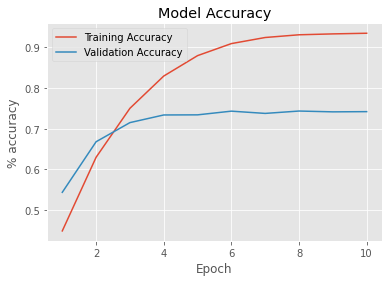

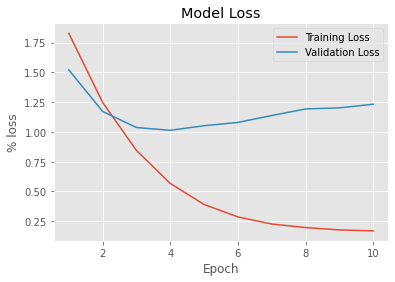

In [163]:
plot_model_results(model_2)

In [164]:
train_pred = model_2.predict(X_train)
test_pred = model_2.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.9412235906678682
test accuracy = 0.7435061219819201


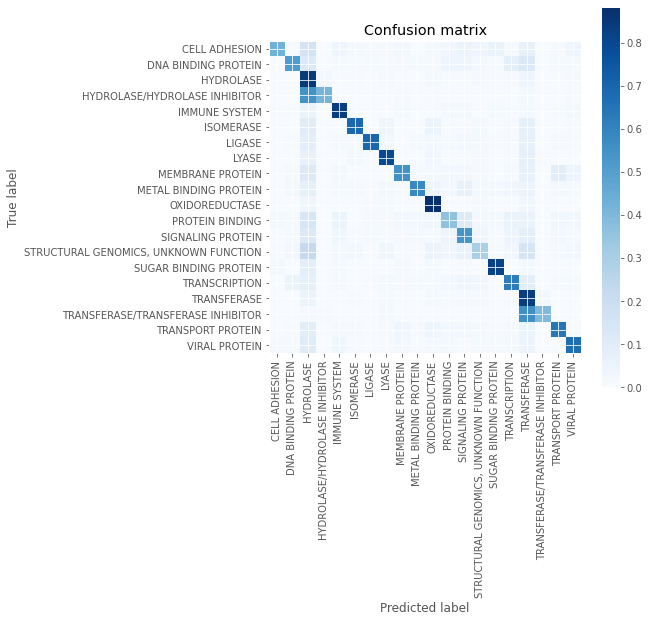

In [165]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [166]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                       precision    recall  f1-score   support

                        CELL ADHESION       0.77      0.43      0.55       259
                  DNA BINDING PROTEIN       0.61      0.51      0.55       278
                            HYDROLASE       0.74      0.85      0.79      4025
        HYDROLASE/HYDROLASE INHIBITOR       0.67      0.42      0.51       497
                        IMMUNE SYSTEM       0.84      0.84      0.84       786
                            ISOMERASE       0.79      0.69      0.73       519
                               LIGASE       0.83      0.70      0.76       401
                                LYASE       0.79      0.79      0.79       852
                     MEMBRANE PROTEIN       0.63      0.55      0.59       324
                METAL BINDING PROTEIN       0.66      0.58      0.62       274
                       OXIDOREDUCTASE       0.88      0.88      0.88      2477
                      PROTEIN BINDING       0.47   

`model_2`
- Achieved slightly lower accuracy on test set with this bidirectional LSTM model
- This actually follows the initial thought that the unidirectional sequence of AAs in the chain matter more, and doing a reverse read on the sequence would not be beneficial considering the sequences are of differing lengths (max=285)

`model_3`
- Revisiting the initial LSTM model from `model_1` 
- Added layer weight regularizers
  - Apply penalties on layer parameters or layer activity during optimization
  - These penalties are summed into the loss function that the network optimizes
  - `kernel_regularizer`: Regularizer to apply a penalty on the layer's kernel
  - `bias_regularizer`: Regularizer to apply a penalty on the layer's bias
  - `activity_regularizer`: Regularizer to apply a penalty on the layer's output

Source:
- https://keras.io/api/layers/regularizers/

In [167]:
model_3 = Sequential()
model_3.add(Embedding(25, 20, input_length=285))

model_3.add(LSTM(25,
                 kernel_regularizer=l2(0.01),
                 recurrent_regularizer=l2(0.01),
                 bias_regularizer=l2(0.01),
                 return_sequences=True))

model_3.add(Flatten())
model_3.add(Dense(285, activation='sigmoid'))
model_3.add(Dense(20, activation='softmax'))
model_3.add(Dropout(0.5))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 285, 20)           500       
_________________________________________________________________
lstm_2 (LSTM)                (None, 285, 25)           4600      
_________________________________________________________________
flatten_4 (Flatten)          (None, 7125)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 285)               2030910   
_________________________________________________________________
dense_9 (Dense)              (None, 20)                5720      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
Total params: 2,041,730
Trainable params: 2,041,730
Non-trainable params: 0
____________________________________________

In [168]:
model_3.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=15, callbacks=early_stopping)

Epoch 1/15
2185/2185 [==============================] - 37s 16ms/step - loss: 8.9138 - accuracy: 0.2389 - val_loss: 1.9008 - val_accuracy: 0.4193
Epoch 2/15
2185/2185 [==============================] - 35s 16ms/step - loss: 8.7451 - accuracy: 0.2814 - val_loss: 1.7128 - val_accuracy: 0.4766
Epoch 3/15
2185/2185 [==============================] - 35s 16ms/step - loss: 8.6296 - accuracy: 0.3024 - val_loss: 1.6648 - val_accuracy: 0.4936
Epoch 4/15
2185/2185 [==============================] - 35s 16ms/step - loss: 8.5949 - accuracy: 0.3200 - val_loss: 1.4764 - val_accuracy: 0.5598
Epoch 5/15
2185/2185 [==============================] - 35s 16ms/step - loss: 8.5366 - accuracy: 0.3410 - val_loss: 1.2846 - val_accuracy: 0.6216
Epoch 6/15
2185/2185 [==============================] - 35s 16ms/step - loss: nan - accuracy: 0.1949 - val_loss: nan - val_accuracy: 0.0145
Epoch 7/15
2185/2185 [==============================] - 35s 16ms/step - loss: nan - accuracy: 0.0145 - val_loss: nan - val_accurac

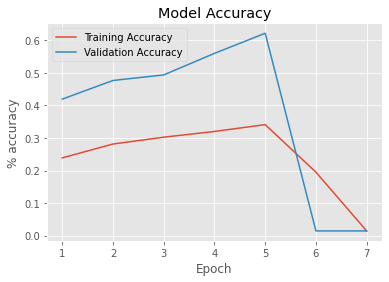

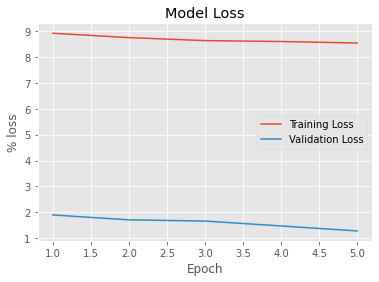

In [169]:
plot_model_results(model_3)

In [170]:
train_pred = model_3.predict(X_train)
test_pred = model_3.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.6215937862077844
test accuracy = 0.5650532097493992


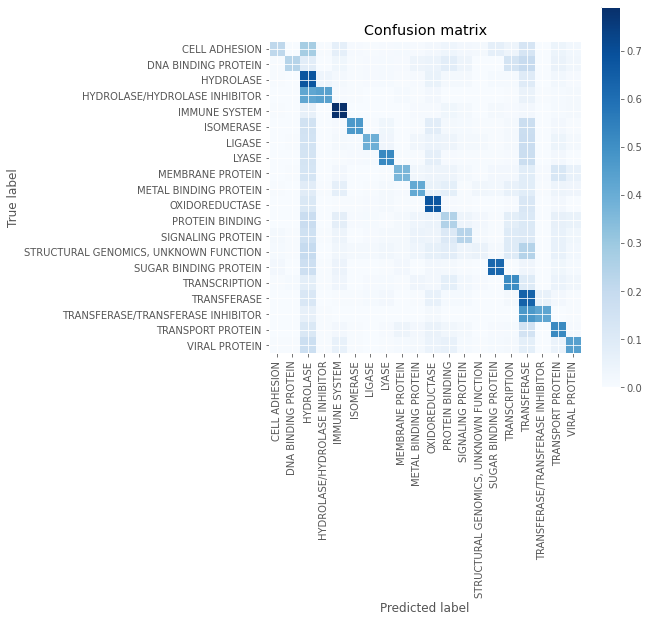

In [171]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [172]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                       precision    recall  f1-score   support

                        CELL ADHESION       0.51      0.22      0.30       259
                  DNA BINDING PROTEIN       0.67      0.24      0.35       278
                            HYDROLASE       0.60      0.68      0.64      4025
        HYDROLASE/HYDROLASE INHIBITOR       0.55      0.44      0.49       497
                        IMMUNE SYSTEM       0.68      0.79      0.73       786
                            ISOMERASE       0.75      0.47      0.58       519
                               LIGASE       0.58      0.39      0.47       401
                                LYASE       0.67      0.52      0.59       852
                     MEMBRANE PROTEIN       0.49      0.37      0.42       324
                METAL BINDING PROTEIN       0.36      0.41      0.38       274
                       OXIDOREDUCTASE       0.70      0.68      0.69      2477
                      PROTEIN BINDING       0.19   

`model_3`
- Addition of regularizers did not help model performance

`model_4`
- Re-run `model_1` because it was the most successful
- LSTM layer with same parameters
- Run 50 epochs
- Increase `patience` to `5` in `early_stopping` callback
- Should see the `accuracy` and `loss` curves approach asymptotes, approximately to 95% and 15%, respectively

In [173]:
model_4 = Sequential()
model_4.add(Embedding(25, 20, input_length=285))

model_4.add(LSTM(25, return_sequences=True))

model_4.add(Flatten())
model_4.add(Dense(285, activation='sigmoid'))
model_4.add(Dense(20, activation='softmax'))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=5)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 285, 20)           500       
_________________________________________________________________
lstm_3 (LSTM)                (None, 285, 25)           4600      
_________________________________________________________________
flatten_5 (Flatten)          (None, 7125)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 285)               2030910   
_________________________________________________________________
dense_11 (Dense)             (None, 20)                5720      
Total params: 2,041,730
Trainable params: 2,041,730
Non-trainable params: 0
_________________________________________________________________


In [174]:
model_4.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=50, callbacks=early_stopping)

Epoch 1/50
2185/2185 [==============================] - 37s 16ms/step - loss: 1.8219 - accuracy: 0.4509 - val_loss: 1.3573 - val_accuracy: 0.5961
Epoch 2/50
2185/2185 [==============================] - 37s 17ms/step - loss: 1.2215 - accuracy: 0.6386 - val_loss: 0.8291 - val_accuracy: 0.7614
Epoch 3/50
2185/2185 [==============================] - 38s 17ms/step - loss: 0.8076 - accuracy: 0.7595 - val_loss: 0.5185 - val_accuracy: 0.8520
Epoch 4/50
2185/2185 [==============================] - 38s 17ms/step - loss: 0.5330 - accuracy: 0.8396 - val_loss: 0.3434 - val_accuracy: 0.9009
Epoch 5/50
2185/2185 [==============================] - 38s 17ms/step - loss: 0.3614 - accuracy: 0.8888 - val_loss: 0.2444 - val_accuracy: 0.9277
Epoch 6/50
2185/2185 [==============================] - 38s 17ms/step - loss: 0.2633 - accuracy: 0.9154 - val_loss: 0.1907 - val_accuracy: 0.9375
Epoch 7/50
2185/2185 [==============================] - 38s 17ms/step - loss: 0.2140 - accuracy: 0.9282 - val_loss: 0.1639 -

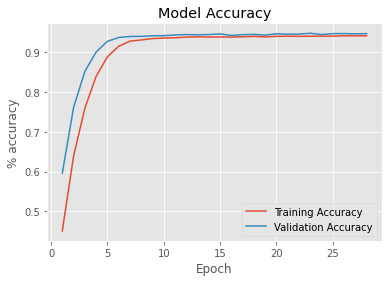

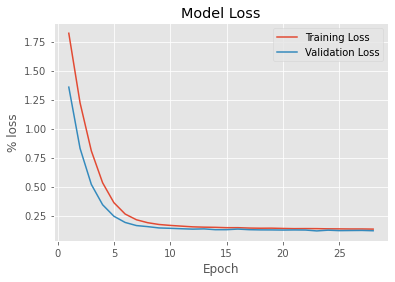

In [175]:
plot_model_results(model_4)

In [176]:
train_pred = model_4.predict(X_train)
test_pred = model_4.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.948175485273713
test accuracy = 0.7431056184918183


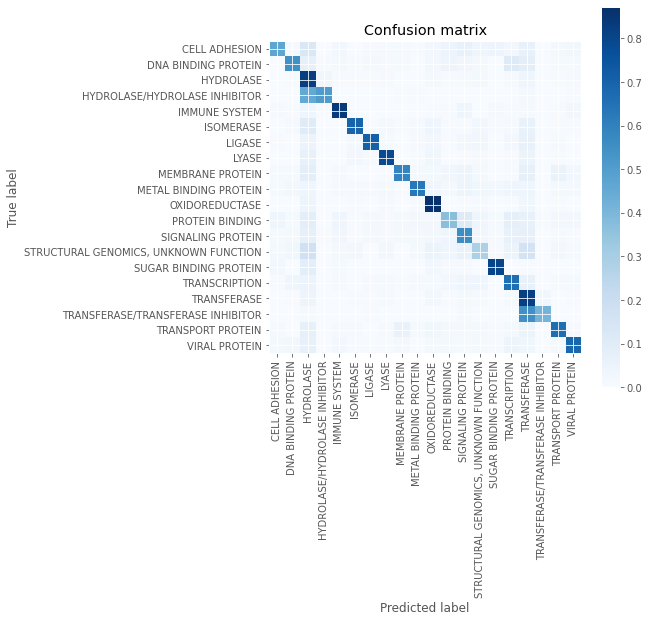

In [177]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [178]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                       precision    recall  f1-score   support

                        CELL ADHESION       0.56      0.47      0.51       259
                  DNA BINDING PROTEIN       0.56      0.55      0.55       278
                            HYDROLASE       0.77      0.82      0.80      4025
        HYDROLASE/HYDROLASE INHIBITOR       0.64      0.51      0.57       497
                        IMMUNE SYSTEM       0.86      0.84      0.85       786
                            ISOMERASE       0.76      0.70      0.73       519
                               LIGASE       0.75      0.71      0.73       401
                                LYASE       0.81      0.79      0.80       852
                     MEMBRANE PROTEIN       0.66      0.59      0.62       324
                METAL BINDING PROTEIN       0.66      0.63      0.65       274
                       OXIDOREDUCTASE       0.88      0.87      0.87      2477
                      PROTEIN BINDING       0.50   

`model_4` works well and we're achieving high precision on some of the most ubiquitous classes:

                                        precision    recall  f1-score   support
                        IMMUNE SYSTEM       0.86      0.84      0.85       786
                                LYASE       0.81      0.79      0.80       852
                       OXIDOREDUCTASE       0.88      0.87      0.87      2477
                SUGAR BINDING PROTEIN       0.80      0.80      0.80       296


### Last thing to try!
- Pare down classes to top 10, run `model_4` and let's see if we can improve precision for more classes

In [179]:
data

,sequence,classification,seq_char_count
40,PPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKAS...,TRANSFERASE/TRANSFERASE INHIBITOR,209
67,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,HYDROLASE,286
74,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,LIGASE,330
76,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,HYDROLASE,124
78,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,HYDROLASE,124
...,...,...,...
471040,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,HYDROLASE/HYDROLASE INHIBITOR,99
471115,APVRSLNCTLRDSQQKSLVMSGPYELKALHLQGQDMEQQVVFSMSF...,SIGNALING PROTEIN,153
471118,STQAATASSRNSCAADDKATEPLPKDCPVSSYNEWDPLEEVIVGRA...,TRANSFERASE,386
471123,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,HYDROLASE/HYDROLASE INHIBITOR,198


In [180]:
data['classification'].value_counts()[:10]

HYDROLASE                        20383
TRANSFERASE                      15340
OXIDOREDUCTASE                   12173
LYASE                             4239
IMMUNE SYSTEM                     3989
TRANSCRIPTION                     3479
TRANSPORT PROTEIN                 3174
SIGNALING PROTEIN                 2845
HYDROLASE/HYDROLASE INHIBITOR     2650
ISOMERASE                         2531
Name: classification, dtype: int64

In [181]:
# only keep top 10 classifications
counts = data.classification.value_counts()
hello = np.asarray(counts[(counts > 2530)].index)

In [182]:
data_top10 = data[data.classification.isin(hello)]

In [183]:
X = data_top10['sequence']
y = data_top10['classification']

In [184]:
# encode classification labels
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

In [185]:
# encode sequences using tokenizer
# create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)
# represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=285)

In [186]:
# number of distinct characters stored in variable max_id
# this will be part of the input shape (reps each AA)
max_id = len(tokenizer.word_index)
max_id

25

In [187]:
# split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# confirm shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56642, 285), (14161, 285), (56642, 10), (14161, 10))

In [191]:
model_4_top10 = Sequential()
model_4_top10.add(Embedding(25, 10, input_length=285))

model_4_top10.add(LSTM(25, return_sequences=True))

model_4_top10.add(Flatten())
model_4_top10.add(Dense(285, activation='sigmoid'))
model_4_top10.add(Dense(10, activation='softmax'))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=5)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_4_top10.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_4_top10.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 285, 10)           250       
_________________________________________________________________
lstm_5 (LSTM)                (None, 285, 25)           3600      
_________________________________________________________________
flatten_7 (Flatten)          (None, 7125)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 285)               2030910   
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2860      
Total params: 2,037,620
Trainable params: 2,037,620
Non-trainable params: 0
_________________________________________________________________


In [192]:
model_4_top10.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=50, callbacks=early_stopping)

Epoch 1/50
1771/1771 [==============================] - 30s 16ms/step - loss: 1.4310 - accuracy: 0.5062 - val_loss: 1.1584 - val_accuracy: 0.6115
Epoch 2/50
1771/1771 [==============================] - 29s 16ms/step - loss: 1.1023 - accuracy: 0.6374 - val_loss: 0.9009 - val_accuracy: 0.7084
Epoch 3/50
1771/1771 [==============================] - 29s 16ms/step - loss: 0.8563 - accuracy: 0.7252 - val_loss: 0.6116 - val_accuracy: 0.8080
Epoch 4/50
1771/1771 [==============================] - 30s 17ms/step - loss: 0.5819 - accuracy: 0.8168 - val_loss: 0.3903 - val_accuracy: 0.8888
Epoch 5/50
1771/1771 [==============================] - 30s 17ms/step - loss: 0.3576 - accuracy: 0.8875 - val_loss: 0.2170 - val_accuracy: 0.9406
Epoch 6/50
1771/1771 [==============================] - 30s 17ms/step - loss: 0.2174 - accuracy: 0.9312 - val_loss: 0.1397 - val_accuracy: 0.9568
Epoch 7/50
1771/1771 [==============================] - 30s 17ms/step - loss: 0.1495 - accuracy: 0.9516 - val_loss: 0.1104 -

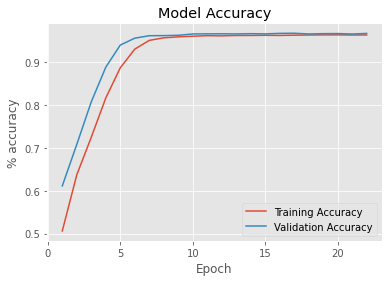

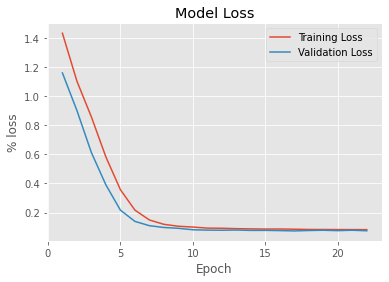

In [193]:
plot_model_results(model_4_top10)

In [194]:
train_pred = model_4_top10.predict(X_train)
test_pred = model_4_top10.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.968292080081918
test accuracy = 0.8021326177529835


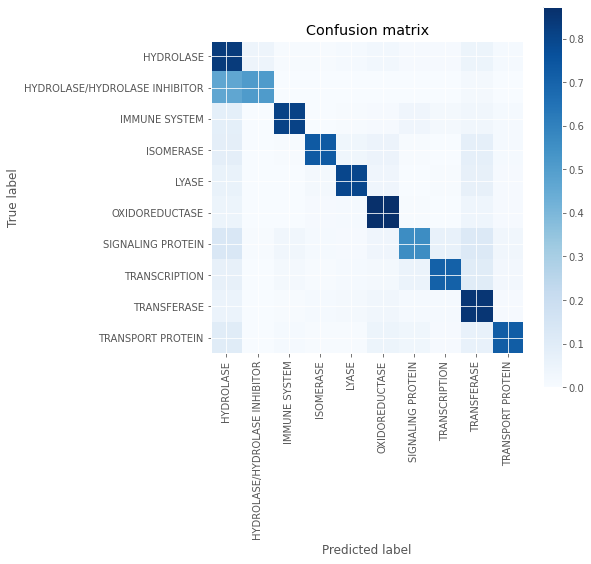

In [195]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [196]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                               precision    recall  f1-score   support

                    HYDROLASE       0.80      0.83      0.81      4030
HYDROLASE/HYDROLASE INHIBITOR       0.59      0.51      0.55       516
                IMMUNE SYSTEM       0.88      0.81      0.84       780
                    ISOMERASE       0.77      0.73      0.75       507
                        LYASE       0.81      0.80      0.80       880
               OXIDOREDUCTASE       0.87      0.87      0.87      2422
            SIGNALING PROTEIN       0.66      0.56      0.61       636
                TRANSCRIPTION       0.75      0.71      0.73       673
                  TRANSFERASE       0.82      0.85      0.83      3087
            TRANSPORT PROTEIN       0.76      0.72      0.74       630

                     accuracy                           0.80     14161
                    macro avg       0.77      0.74      0.75     14161
                 weighted avg       0.80      0.80      0.80     14161



## Conclusions
- Using only the top 10 classes definitely helps the model focus on the most frequently classified proteins
- Sequences are highly conserved in the classification of protein function
- RNNs are the best models for protein classification based on amino acid sequences, specifically adding the LSTM layer
  - This solves the problem of having short term memory (as with RNN) so we incorporate a cell (LSTM) that help regulate the flow of information
  - LSTMs are good at processing long strings of sequences

## Future Steps
- Incorporate the data on physical properties and feed into an ML model
- Build a pipeline to take in this data and include the sequence information
